In [1]:
import torch
import torch_geometric
from torch_geometric.nn import GCNConv, ChebConv  # noqa
import time
import networkx as nx
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from importlib import reload
from best_params import best_params_dict #, default_args
import data as dt
from GNN import GNN
from run_GNN import get_optimizer, train, test

In [2]:
!pwd

/home/huy/graph-neural-pde/notebooks


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
opt = {'KNN_online': False, 'KNN_online_reps': 4, 'KNN_space': 'pos_distance', 'M_nodes': 64, 'add_source': False, 'adjoint': False, 'adjoint_method': 'adaptive_heun', 'adjoint_step_size': 1, 'alpha': 1.0, 'alpha_dim': 'sc', 'att_samp_pct': 1, 'attention_dim': 64, 'attention_dropout': 0.0, 'attention_norm_idx': 0, 'attention_type': 'scaled_dot', 'augment': False, 'batch_norm': False, 'beltrami': False, 'beta_dim': 'sc', 'block': 'constant', 'cgnn': False, 'data_norm': 'rw', 'dataset': 'Cora', 'decay': 0.0005, 'directional_penalty': None, 'dropout': 0.0, 'earlystopxT': 3, 'edge_sampling': False, 'edge_sampling_T': 'T0', 'edge_sampling_add': 0.64, 'edge_sampling_add_type': 'importance', 'edge_sampling_epoch': 5, 'edge_sampling_online': False, 'edge_sampling_online_reps': 4, 'edge_sampling_rmv': 0.32, 'edge_sampling_space': 'attention', 'edge_sampling_sym': False, 'epoch': 100, 'exact': False, 'fa_layer': False, 'fa_layer_edge_sampling_rmv': 0.8, 'fc_out': False, 'feat_hidden_dim': 64, 'function': 'laplacian', 'gdc_avg_degree': 64, 'gdc_k': 64, 'gdc_method': 'ppr', 'gdc_sparsification': 'topk', 'gdc_threshold': 0.0001, 'geom_gcn_splits': False, 'gpu': 0, 'heads': 4, 'heat_time': 3.0, 'hidden_dim': 16, 'input_dropout': 0.5, 'jacobian_norm2': None, 'kinetic_energy': None, 'label_rate': 0.5, 'leaky_relu_slope': 0.2, 'lr': 0.01, 'max_iters': 100, 'max_nfe': 1000, 'max_test_steps': 100, 'method': None, 'mix_features': False, 'new_edges': 'random', 'no_alpha_sigmoid': False, 'no_early': False, 'not_lcc': True, 'num_splits': 1, 'ode_blocks': 1, 'optimizer': 'adam', 'planetoid_split': False, 'pos_dist_quantile': 0.001, 'pos_enc_csv': False, 'pos_enc_hidden_dim': 32, 'pos_enc_orientation': 'row', 'pos_enc_type': 'DW64', 'ppr_alpha': 0.05, 'reweight_attention': False, 'rewire_KNN': False, 'rewire_KNN_T': 'T0', 'rewire_KNN_epoch': 5, 'rewire_KNN_k': 64, 'rewire_KNN_sym': False, 'rewiring': None, 'rw_addD': 0.02, 'rw_rmvR': 0.02, 'self_loop_weight': 1.0, 'sparsify': 'S_hat', 'square_plus': False, 'step_size': 1, 'symmetric_attention': False, 'threshold_type': 'topk_adj', 'time': 1.0, 'tol_scale': 1.0, 'tol_scale_adjoint': 1.0, 'total_deriv': None, 'use_cora_defaults': False, 'use_flux': False, 'use_labels': False, 'use_mlp': False}

In [4]:
def train_model(opt, dataset, device):
  model= GNN(opt, dataset, device).to(device)
  data = dataset.data.to(device)
  parameters = [p for p in model.parameters() if p.requires_grad]
  optimizer = get_optimizer(opt['optimizer'], parameters, lr=opt['lr'], weight_decay=opt['decay'])
  best_time = best_epoch = train_acc = val_acc = test_acc = 0
  pos_encoding = None
  this_test = test

  for epoch in range(1, opt['epoch']):
    start_time = time.time()
    loss = train(model, optimizer, data, pos_encoding)
    tmp_train_acc, tmp_val_acc, tmp_test_acc = this_test(model, data, pos_encoding, opt)

    best_time = opt['time']
    if tmp_val_acc > val_acc:
      best_epoch = epoch
      train_acc = tmp_train_acc
      val_acc = tmp_val_acc
      test_acc = tmp_test_acc
      best_time = opt['time']

    log = 'Epoch: {:03d}, Runtime {:03f}, Loss {:03f}, forward nfe {:d}, backward nfe {:d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Best time: {:.4f}'

    print(log.format(epoch, time.time() - start_time, loss, model.fm.sum, model.bm.sum, train_acc, val_acc, test_acc, best_time))
  print('best val accuracy {:03f} with test accuracy {:03f} at epoch {:d} and best time {:03f}'.format(val_acc, test_acc,
                                                                                                      best_epoch,
                                                                                                      best_time))
  return model

In [11]:
dataset = dt.get_dataset(opt, '../data', opt['not_lcc'])
print(dataset)

Cora()


In [12]:
data = dataset.data.to(device)
print(data)
print(data.edge_index[0].unique())
subset = data.edge_index[0].unique()[:200]
print(subset)
data = data.subgraph(subset)
dataset.data = data
model = train_model(opt, dataset, device)

Data(x=[2485, 1433], edge_index=[2, 10138], y=[2485], train_mask=[2485], test_mask=[2485], val_mask=[2485])
tensor([   0,    1,    2,  ..., 2482, 2483, 2484], device='cuda:0')
tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 1

/home/huy/miniconda3/envs/grand/lib/python3.11/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 1, 'max_iters': 100}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


Epoch: 004, Runtime 0.053176, Loss 1.806649, forward nfe 182, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 005, Runtime 0.053932, Loss 1.749185, forward nfe 234, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 006, Runtime 0.051204, Loss 1.660802, forward nfe 286, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 007, Runtime 0.050660, Loss 1.468640, forward nfe 338, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 008, Runtime 0.051007, Loss 1.448403, forward nfe 390, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 009, Runtime 0.056319, Loss 1.248838, forward nfe 442, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 010, Runtime 0.057506, Loss 1.152513, forward nfe 494, backward nfe 0, Train: 0.4286, Val: 0.2091, Test: 0.1842, Best time: 1.0000
Epoch: 011, Runtime 0.054839, Loss

In [13]:
def draw_graph(data):
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)
    print(g)
    pos = nx.spring_layout(g, k=0.5, iterations=20)
    # pos = nx.spiral_layout(g)
    node_colors = np.linspace(0, 1, len(g.nodes))
    edge_colors = np.linspace(0, 1, len(g.edges))
    plt.figure(3,figsize=(12,12)) 
    nx.draw(g, node_color=node_colors, node_size=10, edge_color=edge_colors, pos=pos)
    plt.show()

Graph with 200 nodes and 35 edges


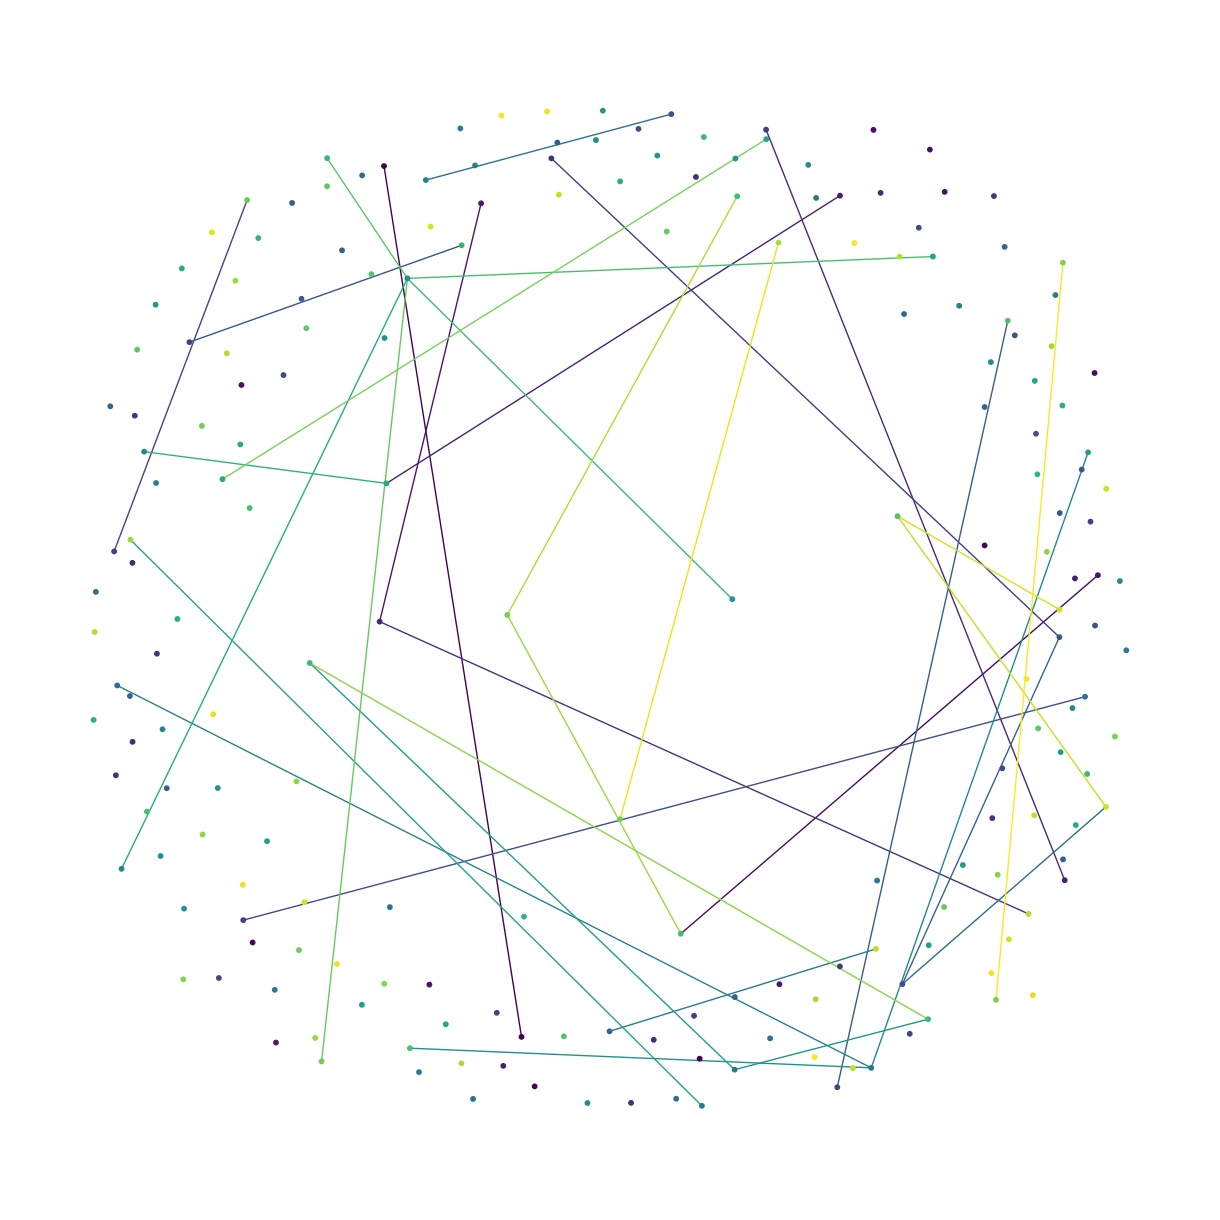

In [14]:
data = dataset.data
draw_graph(data)

In [15]:
attention = model.odeblock.odefunc.attention_weights
edges = model.odeblock.odefunc.edge_index

Graph with 200 nodes and 235 edges


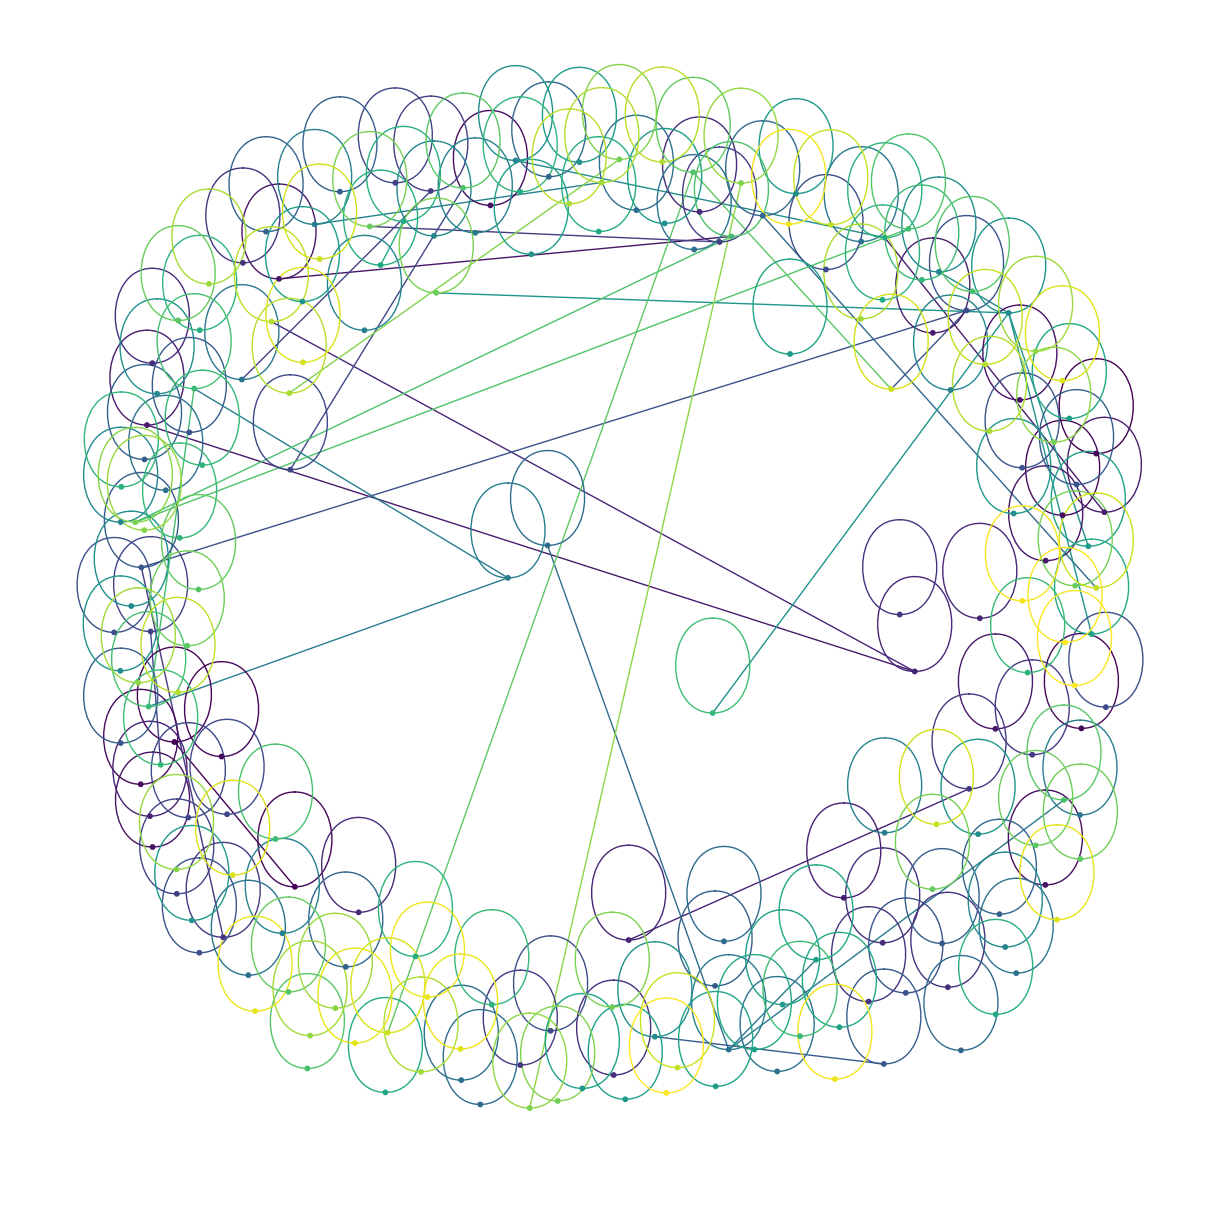

In [16]:
dat2 = dataset.data
dat2.edge_index = edges
draw_graph(dat2)
